# Sampling SigClust

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sigclust

In [3]:
import numpy as np
np.random.seed(824)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
toy = pd.read_csv('examples/sigclust_toy_data.csv', header=None)

In [5]:
toy = toy.T
toy.columns = ['label', 'x1', 'x2']

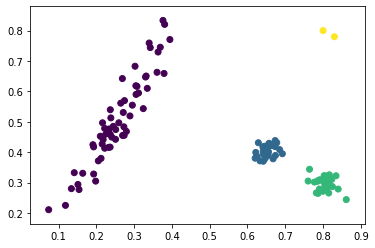

In [6]:
plt.scatter(toy['x1'], toy['x2'], c=toy['label'])

## SigClust does not split the stretched gaussian from the outliers

In [7]:
longcluster_and_outliers = toy[toy['label'].isin((1,4))]

In [11]:
np.random.seed(824)
sc = sigclust.SigClust()
sc.fit(longcluster_and_outliers[['x1', 'x2']], longcluster_and_outliers['label'])
print("p-value: {} \nz-score: {}".format(sc.p_value, sc.z_score))

p-value: 1.0 
z-score: 6.621304975716945


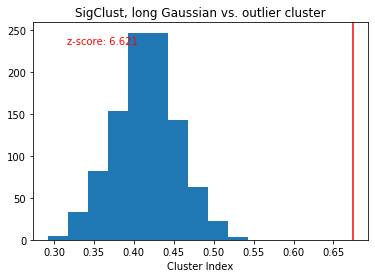

In [10]:
sample_ci2 = sigclust.compute_cluster_index(longcluster_and_outliers[['x1', 'x2']], longcluster_and_outliers['label'])
plt.hist(sc2.simulated_cluster_indices)
plt.axvline(sample_ci2, color='red')
plt.title("SigClust, long Gaussian vs. outlier cluster")
plt.xlabel("Cluster Index")
plt.text(.1, .9, "z-score: {:.3f}".format(sc2.z_score), color='red', transform=plt.gca().transAxes)
plt.show()

Recall that 2-means clustering doesn't split this:

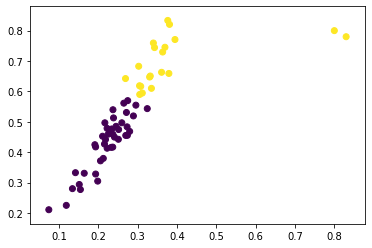

In [148]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(longcluster_and_outliers[['x1', 'x2']])
plt.scatter(longcluster_and_outliers['x1'], longcluster_and_outliers['x2'], c=kmeans.labels_)

What happens with SigClust?

In [149]:
sc = sigclust.SigClust()
sc.fit(longcluster_and_outliers[['x1', 'x2']], kmeans.labels_)

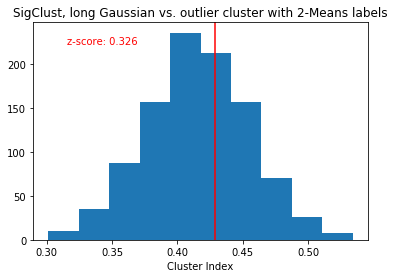

In [151]:
sample_ci = sigclust.compute_cluster_index(longcluster_and_outliers[['x1', 'x2']], kmeans.labels_)
plt.hist(sc.simulated_cluster_indices)
plt.axvline(sample_ci, color='red')
plt.title("SigClust, long Gaussian vs. outlier cluster with 2-Means labels")
plt.xlabel("Cluster Index")
plt.text(.1, .9, "z-score: {:.3f}".format(sc.z_score), color='red', transform=plt.gca().transAxes)
plt.show()

## Generate some more outlier points

In [14]:
stretched_gaussian = toy[toy['label']==1]
outliers = toy[toy['label']==4]

In [18]:
more_outliers = np.random.multivariate_normal(outliers[['x1','x2']].mean(), np.diag([.001,.001]), size=10)
more_outliers = pd.DataFrame(more_outliers, columns=['x1', 'x2'])
more_outliers['label'] = 5
more_outliers.head()

,x1,x2,label
0,0.786687,0.799434,5
1,0.749656,0.756062,5
2,0.836714,0.795876,5
3,0.852536,0.763895,5
4,0.818504,0.767969,5


In [22]:
stretched_gaussian_plus_10_outliers=pd.concat([stretched_gaussian, more_outliers], ignore_index=True)

Finally we plot the stretched gaussian, the original 2 outliers, and the 10 new outliers.

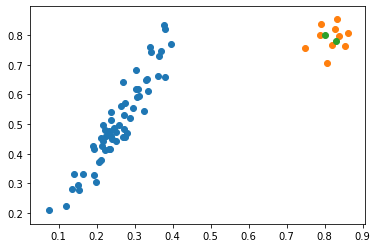

In [25]:
plt.scatter(stretched_gaussian['x1'], stretched_gaussian['x2'])
plt.scatter(more_outliers['x1'], more_outliers['x2'])
plt.scatter(outliers['x1'], outliers['x2'])

## Careful look at sampling scheme

In [13]:
CIs = []
for i in range(1):
    sc = sigclust.SigClust(num_simulations=100)
    sc.fit(newdata[:, 1:3], newdata[:,0])
    CIs.extend(sc.simulated_cluster_indices)

In [34]:
CIs = []
for i in range(100):
    sample_from_majority_class = toy[toy['label']==1][['x1','x2']].sample(10, replace=False)
    new_data = np.concatenate([sample_from_majority_class.values, more_outliers])
    new_labels = np.concatenate([np.repeat(1, 10), np.repeat(2, 10)])
    sc = sigclust.SigClust(100)
    sc.fit(new_data, new_labels)
    CIs.extend(sc.simulated_cluster_indices)

In [35]:
len(CIs)

10000

In [37]:
data_ci = sigclust.compute_cluster_index(newdata[:, 1:3], newdata[:, 0])

In [38]:
z = (data_ci-np.mean(CIs)) / np.std(CIs, ddof=1)
z

6.538701804597116

So for the sampling idea, I got a z score of positive 6.5. So this definitely isn't working.

# Now, I test the weighted sigclust versus the sampling sigclust

In [31]:
data

,label,x1,x2
0,1.0,0.394766,0.770754
1,1.0,0.118407,0.225271
2,1.0,0.238470,0.512960
3,1.0,0.311663,0.594745
4,1.0,0.216500,0.496861
5,1.0,0.339831,0.759281
6,1.0,0.274579,0.569759
7,1.0,0.369293,0.745335
8,1.0,0.271328,0.530824
9,1.0,0.240887,0.449799


In [34]:
from scipy.linalg import sqrtm

In [88]:
def plot_ellipse(ax, data):
    mean = data.mean(axis=0).values
    mean = mean.reshape((len(mean), 1))
    cov = np.cov(data.T)
    ncpts = 401 ;
    vangles = np.linspace(0, 2*np.pi, ncpts) # Equally spaced angles
    mucirc = np.vstack([np.cos(vangles), np.sin(vangles)])  # Equally spaced points on unit circle

    muellips = np.tile(mean, ncpts) + 2 * np.diag((1,1)) @ sqrtm(cov) @ mucirc
    ax.plot(muellips[0,:],muellips[1,:],'k-') 


In [109]:
samples = []
sigclusts = []
sample_cis = []

for i in range(5):
    sample = stretched_gaussian.sample(10, replace=False)
    data = pd.concat([sample, more_outliers], ignore_index=True)
    samples.append(data)
    sample_ci = sigclust.compute_cluster_index(data[['x1','x2']], data['label'])
    sample_cis.append(sample_ci)
    sc = sigclust.SigClust(200)
    sc.fit(data[['x1','x2']], data['label'])
    sigclusts.append(sc)

In [141]:
kmeans_results = []
for i in range(5):
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(samples[i][['x1','x2']])
    kmeans_results.append(kmeans)
    

In [145]:
full_kmeans = KMeans(n_clusters=2)
full_kmeans.fit(stretched_gaussian_plus_10_outliers[['x1','x2']])
kmeans_results.append(full_kmeans)

Text(0.5, 0.98, 'Five Sample Scheme, Colored by 2-Means labels')

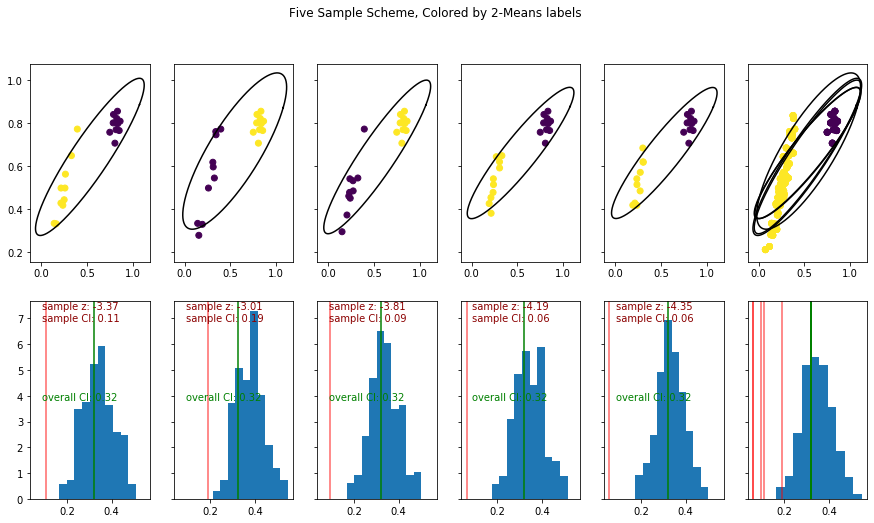

In [147]:
# Plot MVN fit
fig, axes = plt.subplots(2, 6, figsize=(15,8), sharey='row', sharex='row')
overall_ci = sigclust.compute_cluster_index(stretched_gaussian_plus_10_outliers[['x1','x2']], stretched_gaussian_plus_10_outliers['label'])
for i in range(5):
    data = samples[i]
    sc = sigclusts[i]
    sample_ci = sample_cis[i]
    
    axes[0,i].scatter(data['x1'], data['x2'], c=kmeans_results[i].labels_)
    plot_ellipse(axes[0,i], data[['x1','x2']])
    


    # Plot simulated CIs
    ax = axes[1,i]
    ax.hist(sc.simulated_cluster_indices, density=True)
    ax.axvline(sample_ci, color='red', alpha=.6)
    ax.axvline(original_ci, color='green')
    ax.text(.1, .9, "sample z: {:.2f}\nsample CI: {:.2f}".format(sc.z_score, sample_ci), color='darkred', transform=ax.transAxes)
    
    ax.text(.1, .5, "overall CI: {:.2f}".format(overall_ci), color='green', transform=ax.transAxes)
    
axes[1,5].hist(np.concatenate([sc.simulated_cluster_indices for sc in sigclusts]), density=True)

for i in range(5):
    ax = axes[0,5]
    ax.scatter(stretched_gaussian_plus_10_outliers['x1'], stretched_gaussian_plus_10_outliers['x2'], c=kmeans_results[5].labels_)
    plot_ellipse(ax, samples[i][['x1','x2']])
    ax = axes[1,5]
    ax.axvline(sample_cis[i], color='red', alpha=.6)
    ax.axvline(original_ci, color='green')
    
fig.suptitle('Five Sample Scheme, Colored by 2-Means labels')


    
    

Why are the sample CIs so much smaller than the overall CI?

In [135]:
sc = sigclust.SigClust()
sc.fit(stretched_gaussian_plus_10_outliers[['x1','x2']], stretched_gaussian_plus_10_outliers['label'])

In [116]:
ssc = sigclust.SamplingSigClust(num_samplings=5, num_simulations_per_sample=200)
ssc.fit(stretched_gaussian_plus_10_outliers[['x1','x2']], stretched_gaussian_plus_10_outliers['label'])

Text(0.5, 1.0, 'Sampling SigClust')

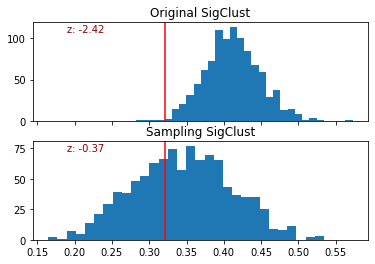

In [136]:
fig, axes = plt.subplots(2,1, sharex=True)
ax = axes[0]
ax.hist(sc.simulated_cluster_indices, bins=30)
sample_ci = sigclust.compute_cluster_index(stretched_gaussian_plus_10_outliers[['x1','x2']], stretched_gaussian_plus_10_outliers['label'])
ax.axvline(sample_ci, color='red')
ax.text(.1, .9, "z: {:.2f}".format(sc.z_score), color='darkred', transform=ax.transAxes)
ax.set_title("Original SigClust")

ax = axes[1]
ax.hist(ssc.simulated_cluster_indices, bins=30)
ax.axvline(sample_ci, color='red')
ax.text(.1, .9, "z: {:.2f}".format(ssc.z_score), color='darkred', transform=ax.transAxes)
ax.set_title("Sampling SigClust")

## Weighted SigClust

In [22]:
wsc = sigclust.WeightedSigClust(conservative=True)
wsc.fit(newdata[:, 1:3], newdata[:,0])

Text(0.5, 1.0, 'Conservative Weighted SigClust (size = n1+n2)')

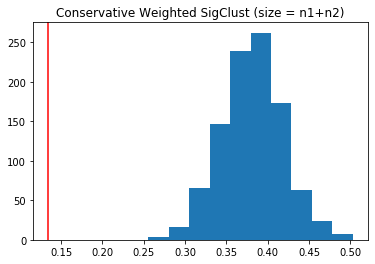

In [33]:
plt.hist(wsc.simulated_cluster_indices)
weighted_ci = sigclust.compute_weighted_cluster_index(stretched_gaussian, more_outliers)
plt.axvline(weighted_ci, color='red')
plt.title("Conservative Weighted SigClust (size = n1+n2)")

In [24]:
wsc2 = sigclust.WeightedSigClust(conservative=False)
wsc2.fit(newdata[:, 1:3], newdata[:,0])

Text(0.5, 1.0, 'Weighted SigClust (size = 2 * n1)')

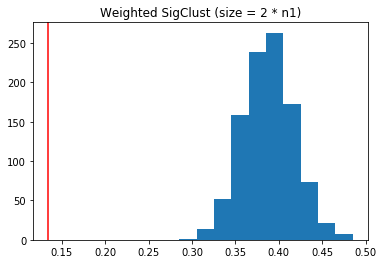

In [32]:
plt.hist(wsc2.simulated_cluster_indices)
plt.axvline(weighted_ci, color='red')
plt.title("Weighted SigClust (size = 2 * n1)")